In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error

#### Preliminary analysis of data and stationarity / ACF / PCF plots for AS14.01

In [2]:
df = pd.read_csv('data/data_arima.csv')

            mood
time            
2014-02-17   NaN
2014-02-18   NaN
2014-02-19   NaN
2014-02-20   NaN
2014-02-21   NaN
...          ...
2014-05-01   8.0
2014-05-02   7.6
2014-05-03   8.0
2014-05-04   8.0
2014-05-05   NaN

[78 rows x 1 columns]


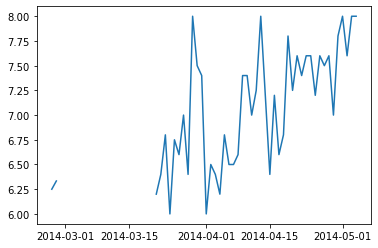

In [3]:
def getPersonMoodArimaSet(person):
    """
        Get the arima mood dataset for a given person.
        
        @param string person:       the id of the person
    """
    # Get mood data for a particular person and set time as index
    mood = df.loc[df["id"] == person][["mood", "time"]]
    mood.set_index(pd.DatetimeIndex(pd.to_datetime(mood.time)), inplace = True)
    mood.drop('time',axis=1,inplace=True)

    # Arima needs a full date range, so fill missing dates
    full_time_range = pd.date_range(mood.index.min(), mood.index.max())
    mood.reindex(full_time_range)
    mood = mood.asfreq('d') # necessary for arima
    
    return mood

mood = getPersonMoodArimaSet("AS14.01")
print(mood)
plt.plot(mood)

#### Stationarity check.

In [4]:
mood_dropna = mood.dropna() ## drop NaN's because adfuller cannot handle nans
result = adfuller(mood_dropna)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5182590351214746
p-value: 0.007530360619884317
Critical Values:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675


This is unexpected to me, because it should be stationary when p value < 0.05 and critical values reasonably close to ADF statistic (according to https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7). 

The graph does not seem stationary to me (there is a clear upwards trend) but these values seem to indicate that the mood data is in fact stationary.

Analyse what happens if we cut off the missing days (there is a big gap) in the beginning and the 1 missing day at the end:

In [5]:
mood_cutoff = mood.iloc[32:-1] ## drop everything before streak
print(mood_cutoff)

            mood
time            
2014-03-21  6.20
2014-03-22  6.40
2014-03-23  6.80
2014-03-24  6.00
2014-03-25  6.75
2014-03-26  6.60
2014-03-27  7.00
2014-03-28  6.40
2014-03-29  8.00
2014-03-30  7.50
2014-03-31  7.40
2014-04-01  6.00
2014-04-02  6.50
2014-04-03  6.40
2014-04-04  6.20
2014-04-05  6.80
2014-04-06  6.50
2014-04-07  6.50
2014-04-08  6.60
2014-04-09  7.40
2014-04-10  7.40
2014-04-11  7.00
2014-04-12  7.25
2014-04-13  8.00
2014-04-14  7.20
2014-04-15  6.40
2014-04-16  7.20
2014-04-17  6.60
2014-04-18  6.80
2014-04-19  7.80
2014-04-20  7.25
2014-04-21  7.60
2014-04-22  7.40
2014-04-23  7.60
2014-04-24  7.60
2014-04-25  7.20
2014-04-26  7.60
2014-04-27  7.50
2014-04-28  7.60
2014-04-29  7.00
2014-04-30  7.80
2014-05-01  8.00
2014-05-02  7.60
2014-05-03  8.00
2014-05-04  8.00


In [6]:
result = adfuller(mood_cutoff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.6796223894258437
p-value: 0.004409086719118722
Critical Values:
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025


#### ACF / PACF analysis

This can only be done when the time series is stationary. According to the adfuller test, the time series is stationary so we will do ACF / PACF to obtain p,d,q.

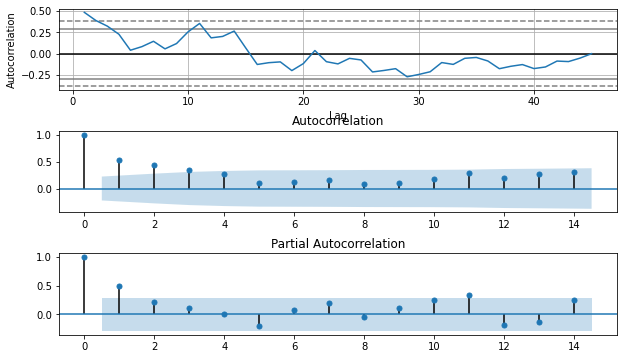

In [7]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

# ACF
autocorrelation_plot(mood_cutoff, ax=ax1) # pandas acf: cannot handle NaN
plot_acf(mood, lags=14, alpha=0.05, use_vlines = True, ax=ax2, missing="drop") # statsmodel acf

# PACF
plot_pacf(mood_cutoff, lags=14, alpha=0.05, use_vlines = True, ax=ax3) # statsmodel acf: cannot handle NaN
plt.show()

Arima try-out

In [8]:
p = 1 # found by acf
d = 0 # no differencing required because already stationary...  (apparantly?)
q = 1 # found by pacf

warnings.filterwarnings("ignore")

Test MSE: 0.24376626533776774


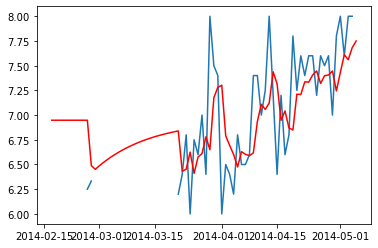

In [9]:
# Train model with whole series
model = ARIMA(mood, order=(p,d,q))
model_fit = model.fit()

# Evaluate results
forecast = model_fit.forecast(len(mood))

# Adjust mood (fill NaNs with forecasted values) so we can get MSE for the present mood data
mood_mse = [y if pd.isna(x[0]) else x[0] for x,y in zip(mood.values, forecast)]
mse = mean_squared_error(mood_mse, forecast)
print(f'Test MSE: {mse}')

# Plot results
plt.plot(mood)
plt.plot(model_fit.fittedvalues, color='red')

Use ARIMA to train and test on unforeseen data. We are gonna check the following sets:
- full range, i.e with the long gap of NaNs at the beginning
- cutoff range, i.e without the long gap and without the first 2 values and without the last value
- dropna, i.e all the non-NaNs

In [10]:
perc_train = 0.8

Test MSE: 0.6544483598207276 	for 1, 0 and 1


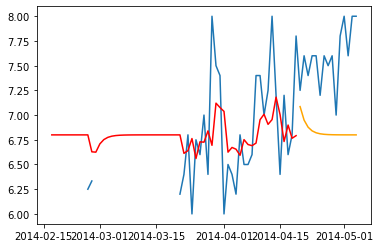

In [11]:
def get_train_set_set(data, perc_train = perc_train):
    """
        Given some data and the desired percentage of the trainign set, return a training set and test set.
        
        @param aray-like data           the data to divide
        @param float perc_train         the training set percentage
    """ 
    # Make training and test set
    train_size = int(len(data) * perc_train) 
    
    return data[0:train_size], data[train_size:].dropna()

def perform_ARIMA(data, pdq_order, perc_train = perc_train):
    """
        Perform arima on some data with a specific order and the desired training set percentage.
 
        @param aray-like data           the data
        @param (int,int,int) pqd_order  the p,d,q order for arima
        @param float perc_train         the training set percentage
        
    """
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)

    # Train the model
    model = ARIMA(train, order=pdq_order)
    model_fit = model.fit()

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    print(f'Test MSE: {mse} \tfor {pdq_order[0]}, {pdq_order[1]} and {pdq_order[2]}')

    # Show observed values, fitted values, and forecasted values
    plt.plot(data)
    plt.plot(model_fit.fittedvalues, color='red') 
    plt.plot(test.index, forecast, color='orange')
    plt.show()
    
perform_ARIMA(mood, (p,d,q))

Test MSE: 0.4960313640274113 	for 1, 0 and 1


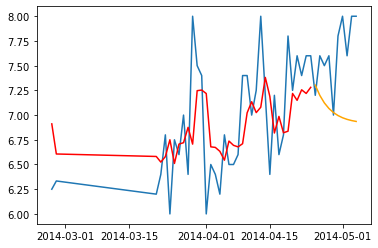

In [12]:
perform_ARIMA(mood_dropna, (p,d,q))

Test MSE: 0.5634167565931091 	for 1, 0 and 1


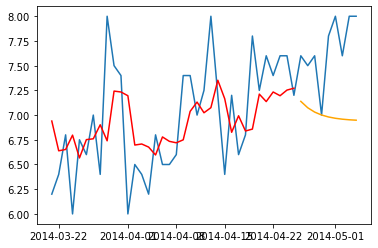

In [13]:
perform_ARIMA(mood_cutoff, (p,d,q))

They are not great. The dropna seems the best though.

Try different p,d,q values because it does not work well with the theoretically obtaines values (1,0,1)

In [14]:
def do_experiment_ARIMA_find_pdq_values(data, p_values, d_values, q_values, doPrint = True):
    """ 
        Try different p,d,q orders on a data-set to find the optimal p,d,q combination.
        
        @param aray-like data           the data to divide
        @param [integers] p_values      the p-values to try
        @param [integers] d_values      the d-values to try
        @param [integers] q_values      the q-values to try
        @param boolean doPrint          whether or not to print the result for each order
    """

    results = []
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)

    # Information wrt sizes of train and test
    train_size_na = int(train.count())
    train_size = int(len(train))
    test_size = int(test.count())
    
    # Try out all p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:

                # Train the model
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                # Forecast and check accuracy
                forecast = model_fit.forecast(len(test))
                mse = mean_squared_error(test, forecast)
                
                if doPrint:
                    print(f'Test MSE: {mse} \t\t\tfor {p}, {d} and {q}')
                
                # Save results
                results.append([p,d,q,mse,train_size_na,train_size,test_size])
            
                # Show observed values, fitted values, and forecasted values
                if doPrint:
                    plt.plot(data)
                    plt.plot(model_fit.fittedvalues, color='red')  
                    plt.plot(test.index, forecast, color='orange')
                    plt.show()

    return pd.DataFrame(results, columns=["p", "d", "q", "mse", "tr_na", "tr", "tst"])
    
p_values = [0,1,2,3,4]
d_values = [0,1,2]
q_values = [0,1,2]

Test MSE: 0.6659477458520975 			for 0, 0 and 0


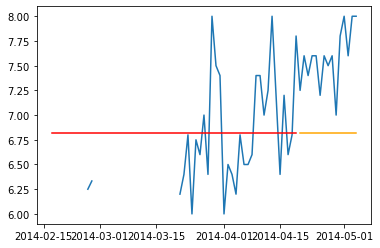

Test MSE: 0.6599634571589753 			for 0, 0 and 1


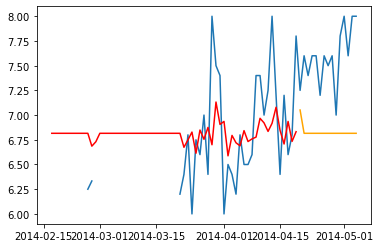

Test MSE: 0.6551077618888148 			for 0, 0 and 2


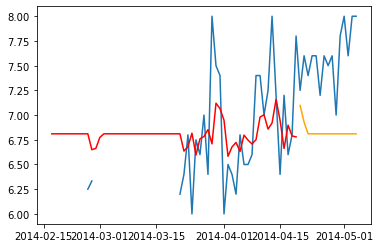

Test MSE: 0.12749999999999959 			for 0, 1 and 0


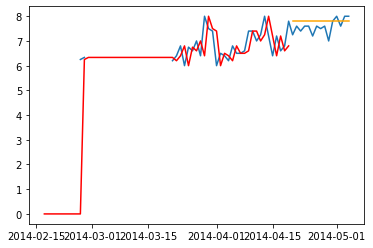

Test MSE: 0.312936279881885 			for 0, 1 and 1


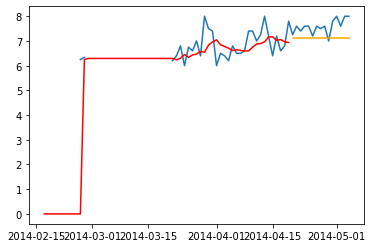

Test MSE: 0.3510911746321484 			for 0, 1 and 2


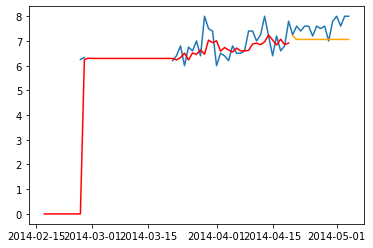

Test MSE: 84.86750000000038 			for 0, 2 and 0


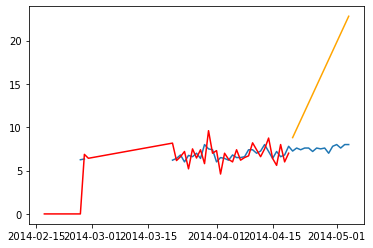

Test MSE: 0.2658776642272948 			for 0, 2 and 1


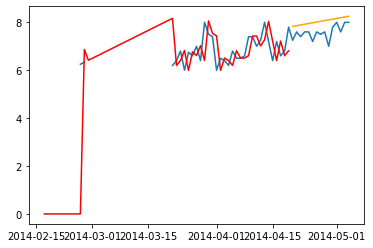

Test MSE: 0.14793820080570644 			for 0, 2 and 2


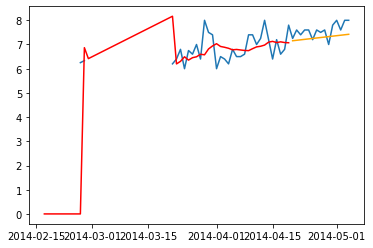

Test MSE: 0.6555128264376139 			for 1, 0 and 0


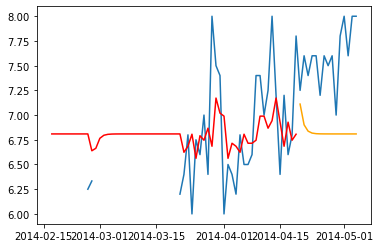

Test MSE: 0.6544483598207276 			for 1, 0 and 1


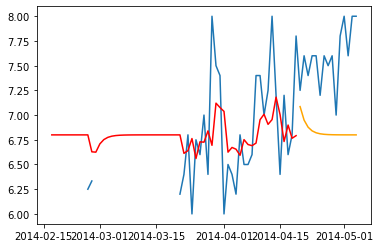

Test MSE: 0.6578351263264517 			for 1, 0 and 2


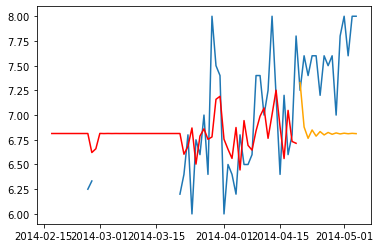

Test MSE: 0.08220007583533341 			for 1, 1 and 0


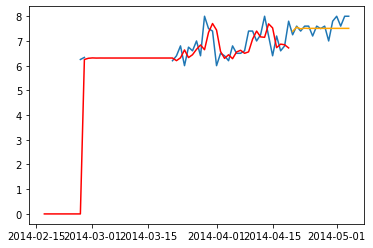

Test MSE: 0.3655243259015169 			for 1, 1 and 1


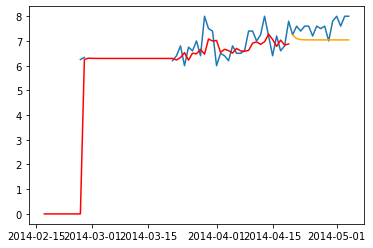

Test MSE: 0.3770542874323914 			for 1, 1 and 2


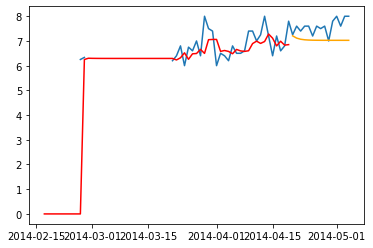

Test MSE: 39.06455369632145 			for 1, 2 and 0


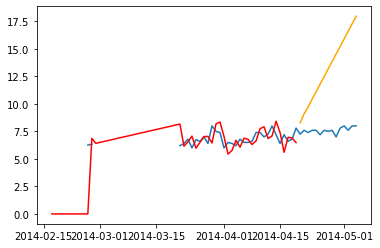

Test MSE: 0.07246922053739314 			for 1, 2 and 1


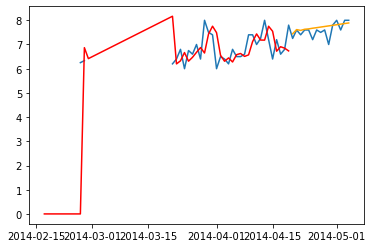

Test MSE: 0.11806996413353604 			for 1, 2 and 2


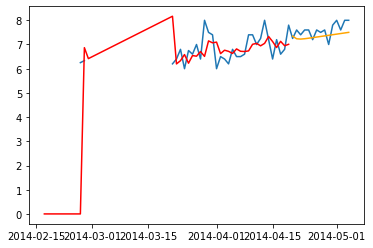

Test MSE: 0.6536246301817742 			for 2, 0 and 0


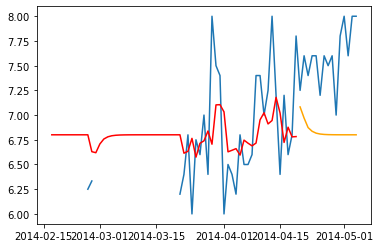

Test MSE: 0.653784317984875 			for 2, 0 and 1


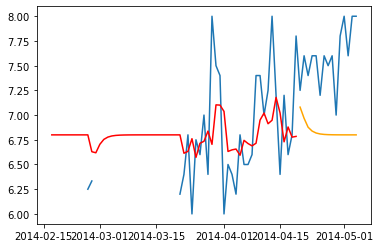

Test MSE: 0.6540170694778411 			for 2, 0 and 2


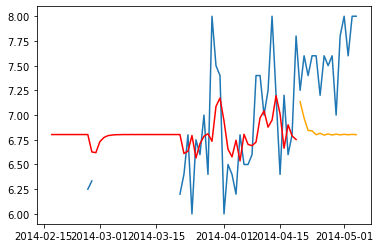

Test MSE: 0.13799562587892525 			for 2, 1 and 0


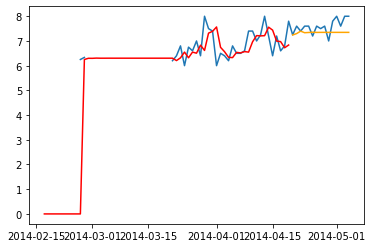

Test MSE: 0.37499834421065736 			for 2, 1 and 1


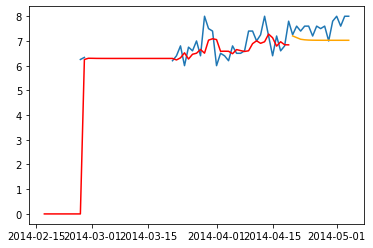

Test MSE: 0.36368512077328397 			for 2, 1 and 2


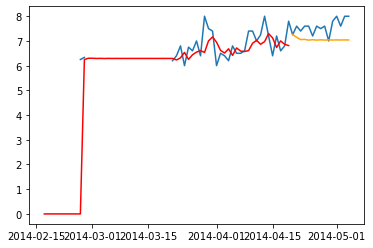

Test MSE: 11.71501782206438 			for 2, 2 and 0


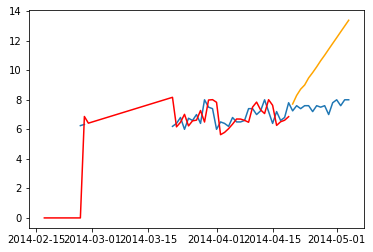

Test MSE: 0.06101042177970197 			for 2, 2 and 1


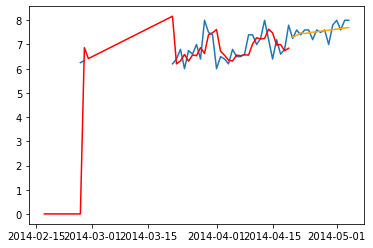

Test MSE: 0.07295287547595189 			for 2, 2 and 2


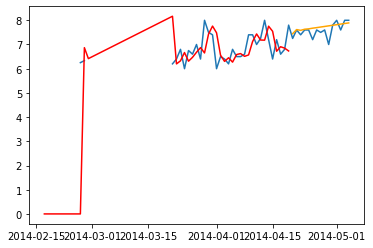

Test MSE: 0.653857170232651 			for 3, 0 and 0


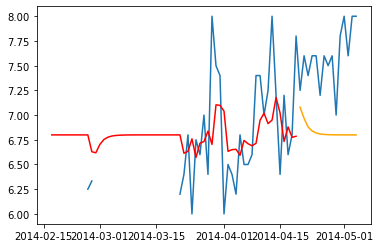

Test MSE: 0.6538644012361876 			for 3, 0 and 1


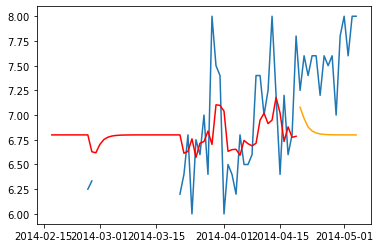

Test MSE: 0.5256833733425418 			for 3, 0 and 2


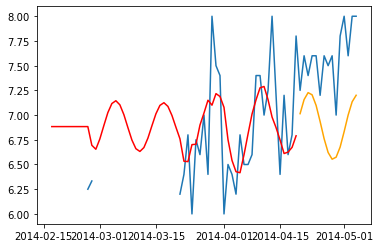

Test MSE: 0.17050235782456483 			for 3, 1 and 0


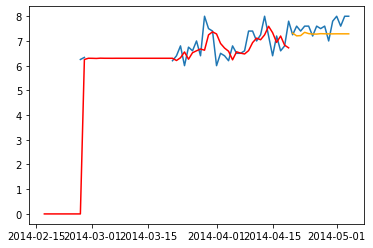

Test MSE: 0.3752187179011784 			for 3, 1 and 1


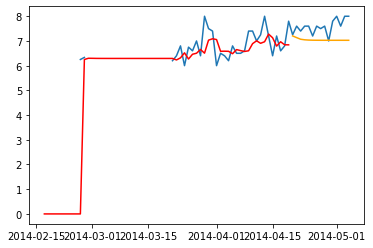

Test MSE: 0.36092255954245617 			for 3, 1 and 2


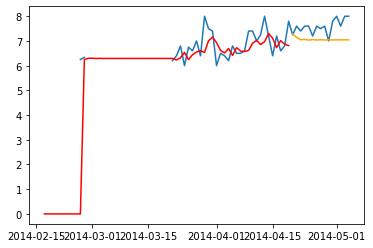

Test MSE: 7.740036322328504 			for 3, 2 and 0


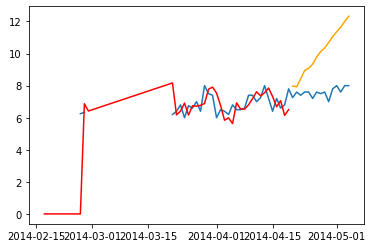

Test MSE: 0.07131311434195445 			for 3, 2 and 1


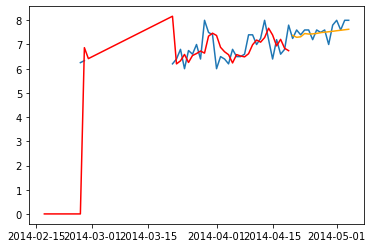

Test MSE: 0.06811566116945127 			for 3, 2 and 2


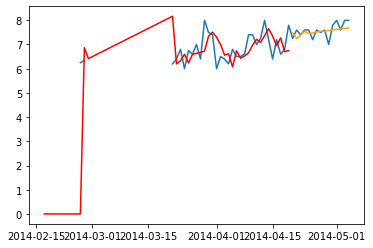

Test MSE: 0.6538794325656468 			for 4, 0 and 0


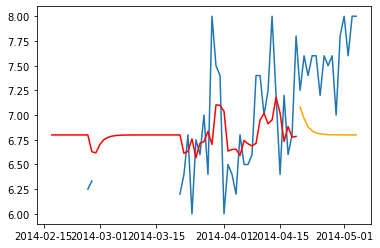

Test MSE: 0.6552771239234113 			for 4, 0 and 1


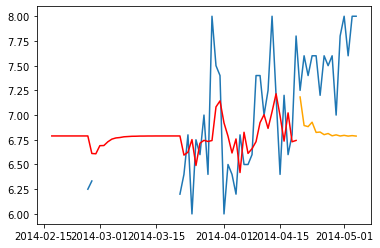

Test MSE: 0.6676366701662455 			for 4, 0 and 2


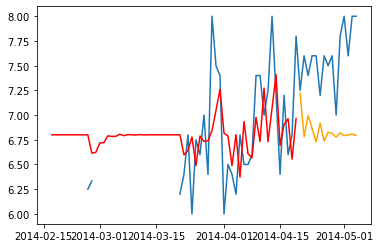

Test MSE: 0.1406436736507771 			for 4, 1 and 0


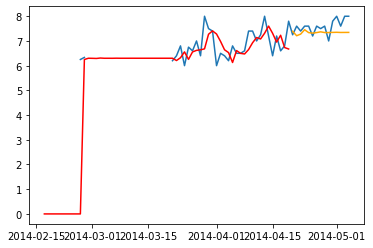

Test MSE: 0.3763395531972706 			for 4, 1 and 1


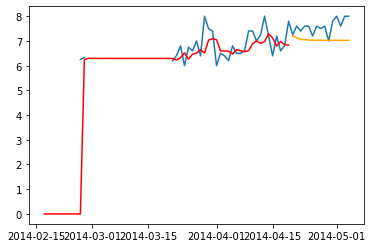

Test MSE: 0.375717045880579 			for 4, 1 and 2


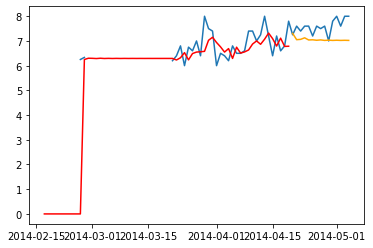

Test MSE: 7.028396167869175 			for 4, 2 and 0


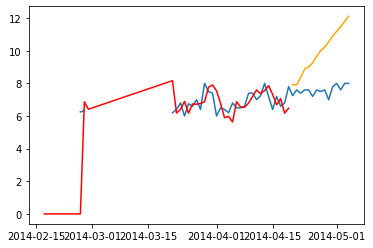

Test MSE: 0.0616496184340999 			for 4, 2 and 1


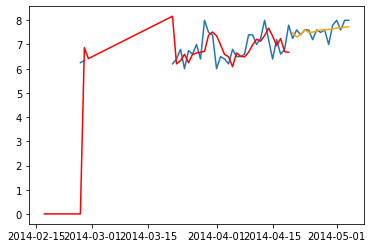

Test MSE: 0.06688821689485963 			for 4, 2 and 2


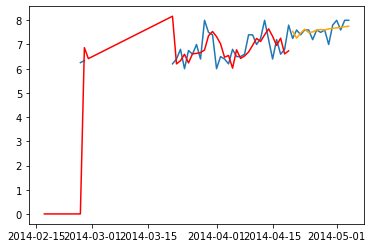

Test MSE: 0.6204873443189418 			for 0, 0 and 0


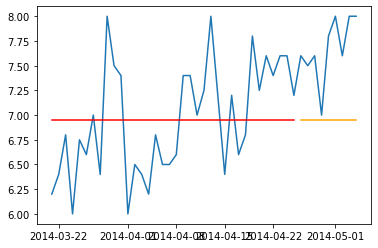

Test MSE: 0.6213055698056977 			for 0, 0 and 1


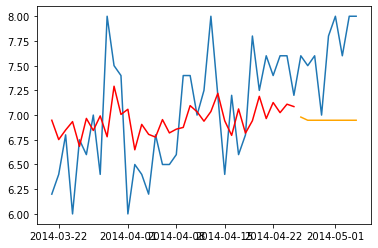

Test MSE: 0.6201330986926308 			for 0, 0 and 2


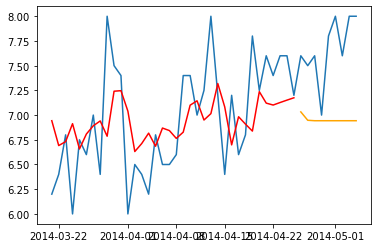

Test MSE: 0.3211111111111117 			for 0, 1 and 0


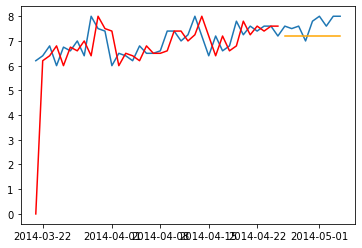

Test MSE: 0.17206217078833103 			for 0, 1 and 1


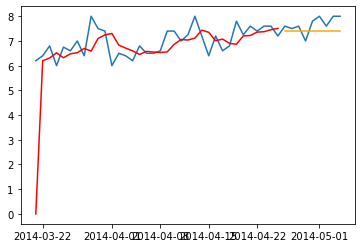

Test MSE: 0.21110985068361804 			for 0, 1 and 2


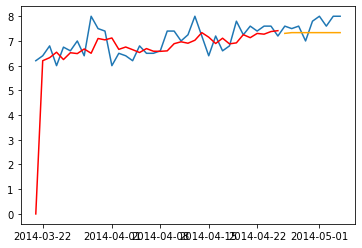

Test MSE: 7.663333334287568 			for 0, 2 and 0


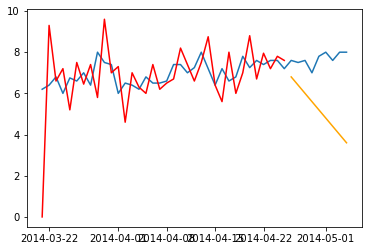

Test MSE: 0.1844215130714677 			for 0, 2 and 1


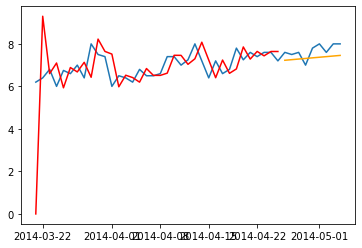

Test MSE: 0.07720755312735066 			for 0, 2 and 2


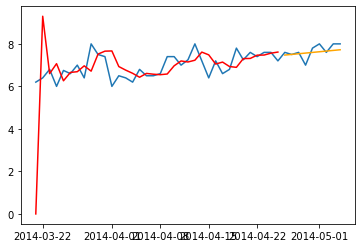

Test MSE: 0.6117909461451805 			for 1, 0 and 0


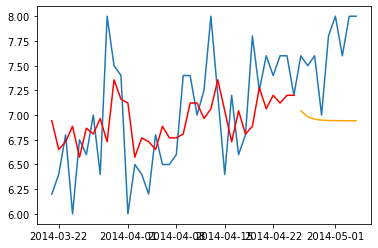

Test MSE: 0.5634167565931091 			for 1, 0 and 1


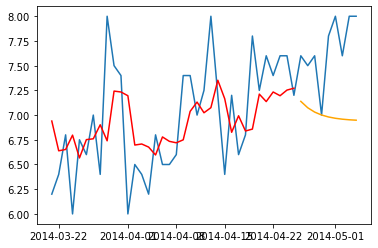

Test MSE: 0.5746169452576265 			for 1, 0 and 2


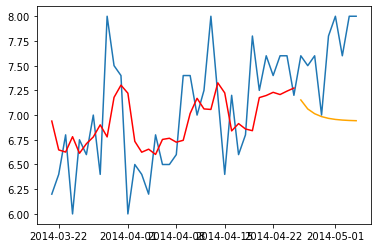

Test MSE: 0.21862596317427255 			for 1, 1 and 0


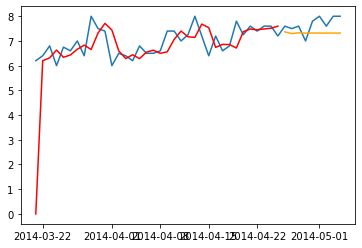

Test MSE: 0.2440748765206373 			for 1, 1 and 1


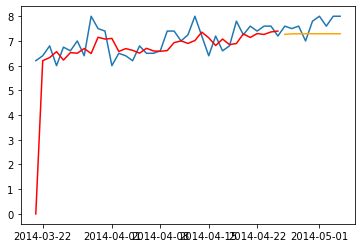

Test MSE: 0.2697134090943741 			for 1, 1 and 2


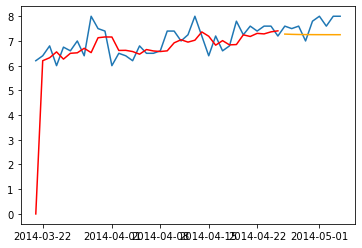

Test MSE: 3.361461643364608 			for 1, 2 and 0


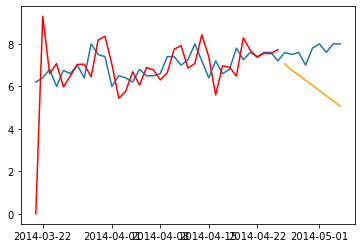

Test MSE: 0.10780391578943009 			for 1, 2 and 1


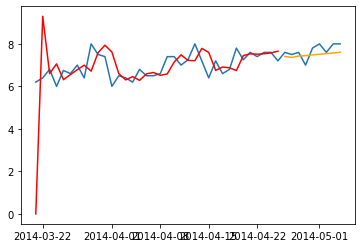

Test MSE: 0.09463468312737314 			for 1, 2 and 2


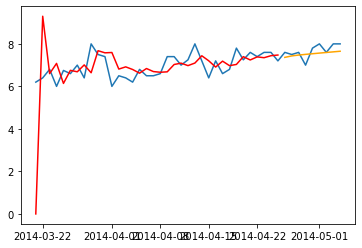

Test MSE: 0.5782845671412868 			for 2, 0 and 0


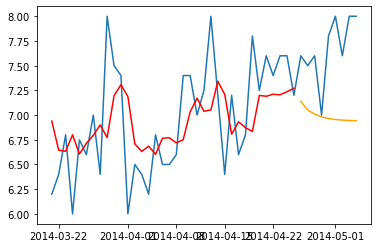

Test MSE: 0.5708733258617751 			for 2, 0 and 1


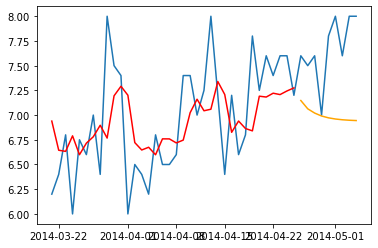

Test MSE: 0.5770823496076412 			for 2, 0 and 2


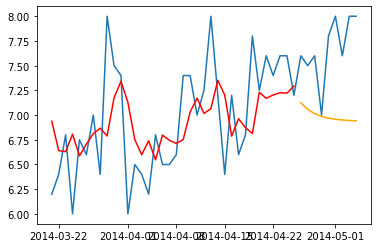

Test MSE: 0.1896433147414237 			for 2, 1 and 0


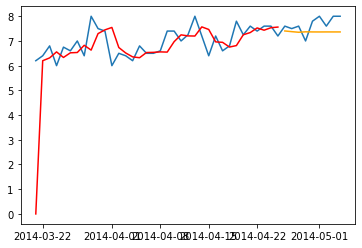

Test MSE: 0.27374637094308296 			for 2, 1 and 1


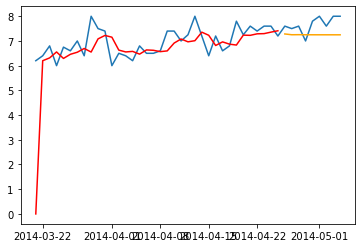

Test MSE: 0.2657768036408072 			for 2, 1 and 2


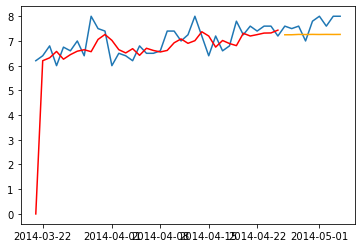

Test MSE: 1.389834008436781 			for 2, 2 and 0


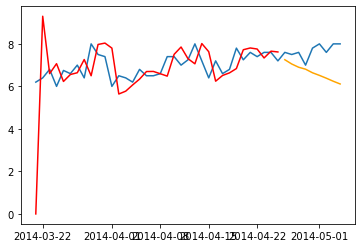

Test MSE: 0.09264724785107589 			for 2, 2 and 1


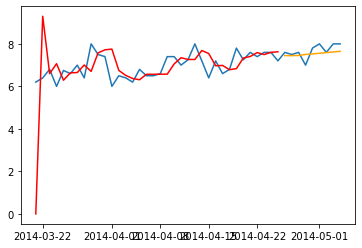

Test MSE: 0.11298633794076898 			for 2, 2 and 2


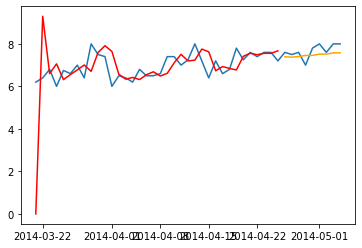

Test MSE: 0.5697278720357407 			for 3, 0 and 0


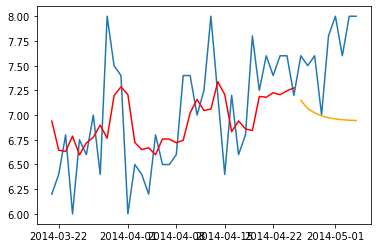

Test MSE: 0.5694946377313828 			for 3, 0 and 1


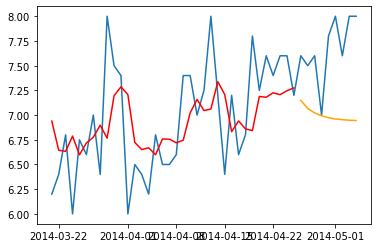

Test MSE: 0.5522420003583073 			for 3, 0 and 2


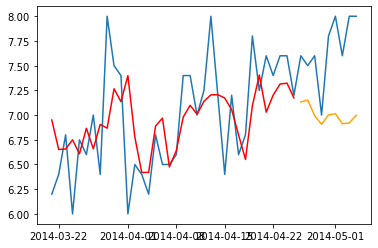

Test MSE: 0.1778163862840757 			for 3, 1 and 0


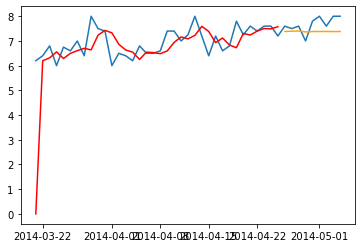

Test MSE: 0.274064352380814 			for 3, 1 and 1


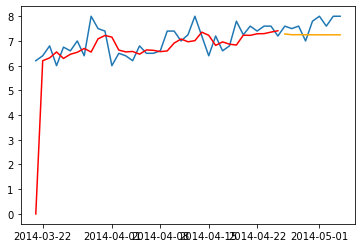

Test MSE: 0.27193342051615316 			for 3, 1 and 2


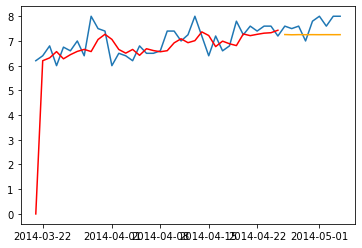

Test MSE: 0.8872440473643246 			for 3, 2 and 0


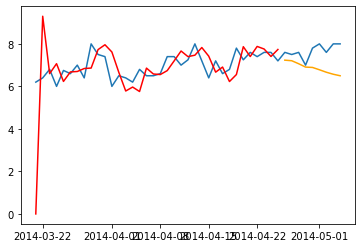

Test MSE: 0.0816173788179037 			for 3, 2 and 1


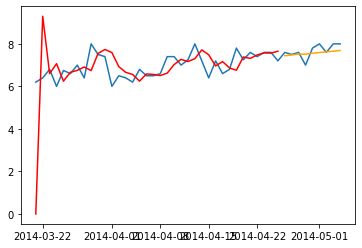

Test MSE: 0.08611575276691151 			for 3, 2 and 2


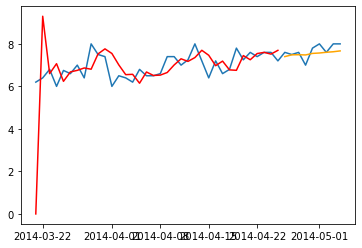

Test MSE: 0.5653558356125813 			for 4, 0 and 0


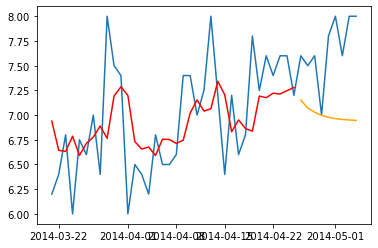

Test MSE: 0.5531519795564557 			for 4, 0 and 1


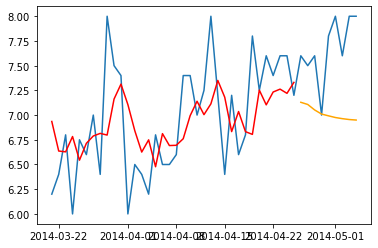

Test MSE: 0.4327955582347556 			for 4, 0 and 2


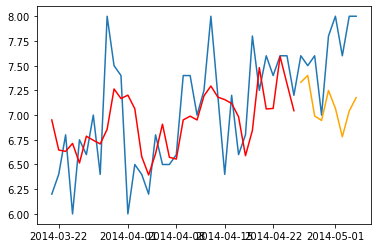

Test MSE: 0.1834646362674254 			for 4, 1 and 0


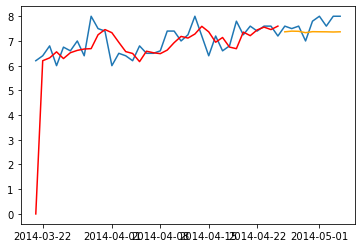

Test MSE: 0.18843350394749717 			for 4, 1 and 1


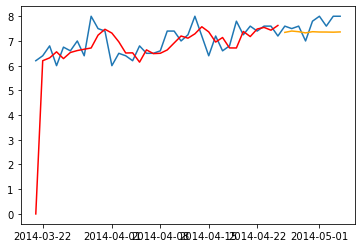

Test MSE: 0.2793497868694084 			for 4, 1 and 2


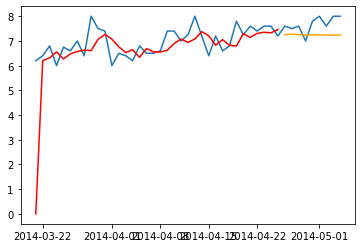

Test MSE: 0.6659020346248681 			for 4, 2 and 0


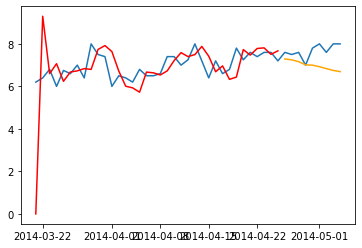

Test MSE: 0.08622269704432127 			for 4, 2 and 1


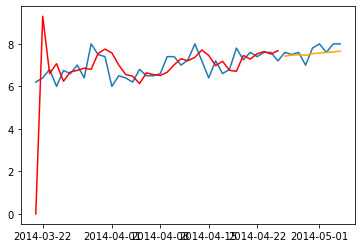

Test MSE: 0.08845154405300977 			for 4, 2 and 2


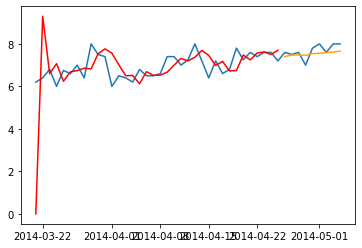

Test MSE: 0.6239352955458067 			for 0, 0 and 0


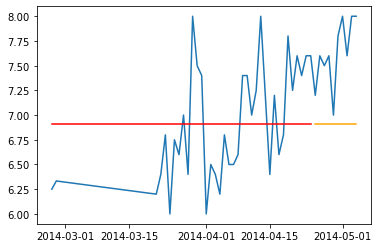

Test MSE: 0.6176516118648271 			for 0, 0 and 1


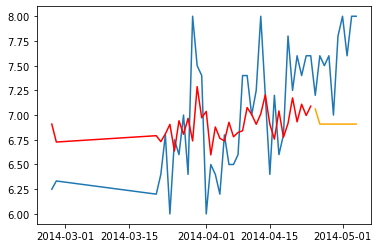

Test MSE: 0.6014008626130402 			for 0, 0 and 2


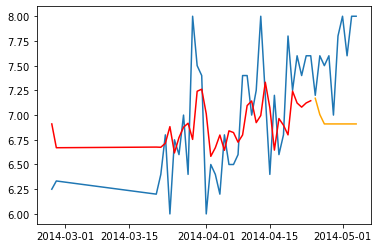

Test MSE: 0.10500000000000001 			for 0, 1 and 0


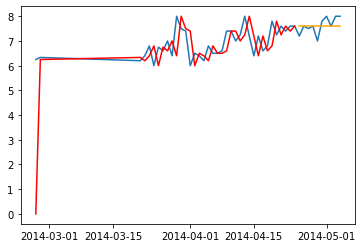

Test MSE: 0.11560735210094841 			for 0, 1 and 1


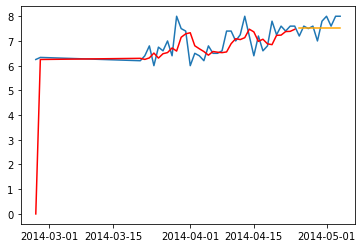

Test MSE: 0.13966148330242883 			for 0, 1 and 2


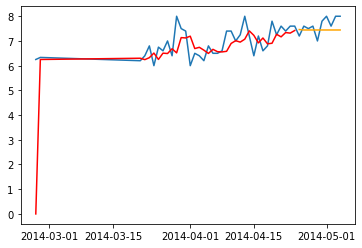

Test MSE: 0.10499999997933744 			for 0, 2 and 0


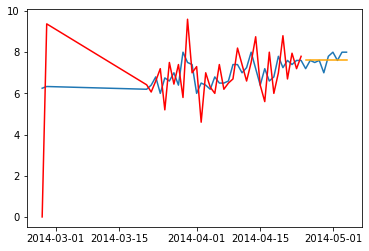

Test MSE: 0.09989118560952744 			for 0, 2 and 1


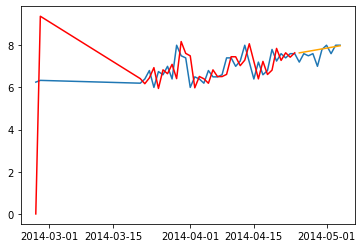

Test MSE: 0.09201519884831344 			for 0, 2 and 2


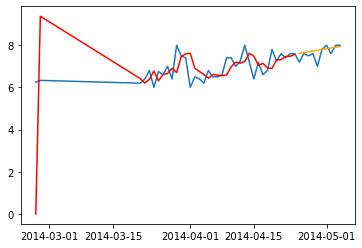

Test MSE: 0.5867603478265423 			for 1, 0 and 0


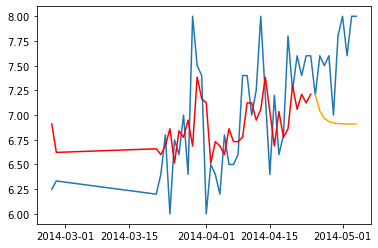

Test MSE: 0.4960313640274113 			for 1, 0 and 1


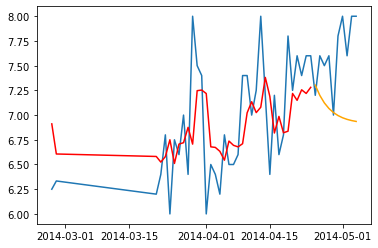

Test MSE: 0.5169845354813034 			for 1, 0 and 2


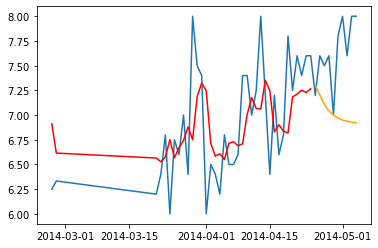

Test MSE: 0.10500000000000001 			for 1, 1 and 0


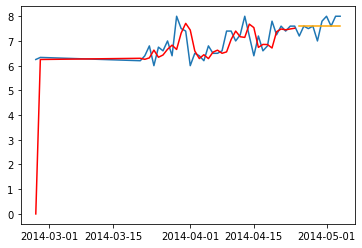

Test MSE: 0.16876808813494265 			for 1, 1 and 1


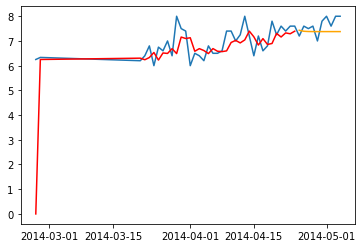

Test MSE: 0.18784480127204714 			for 1, 1 and 2


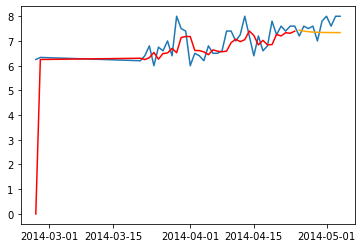

Test MSE: 0.24698204476960495 			for 1, 2 and 0


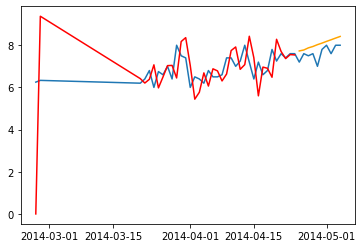

Test MSE: 0.10421301572846826 			for 1, 2 and 1


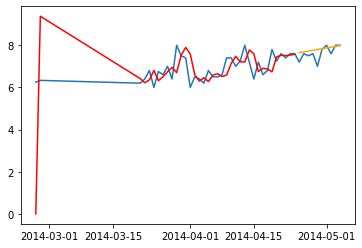

Test MSE: 0.0799948970424992 			for 1, 2 and 2


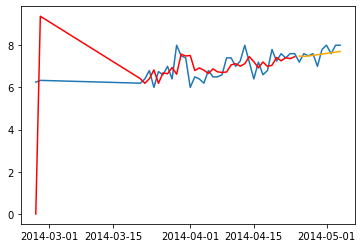

Test MSE: 0.5240816693631705 			for 2, 0 and 0


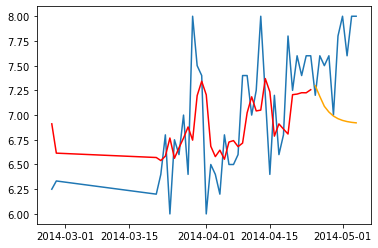

Test MSE: 0.5097453370147351 			for 2, 0 and 1


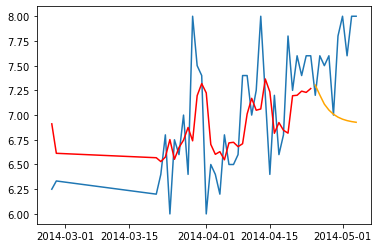

Test MSE: 0.5078367928032799 			for 2, 0 and 2


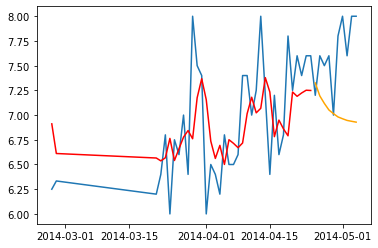

Test MSE: 0.10571530689940697 			for 2, 1 and 0


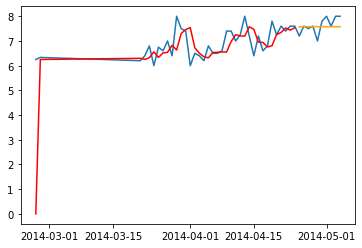

Test MSE: 0.1913554702221368 			for 2, 1 and 1


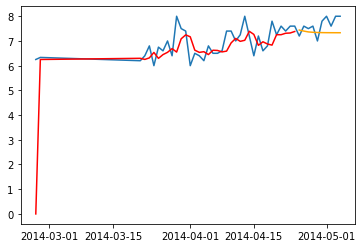

Test MSE: 0.18371150481386084 			for 2, 1 and 2


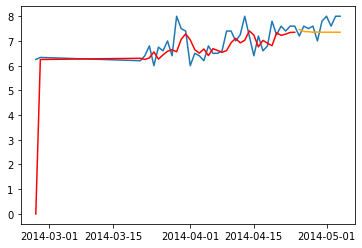

Test MSE: 0.10827371729688817 			for 2, 2 and 0


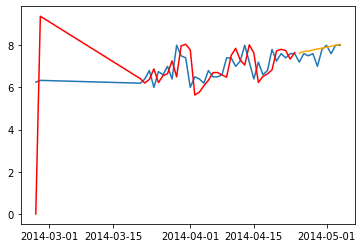

Test MSE: 0.09861301093321097 			for 2, 2 and 1


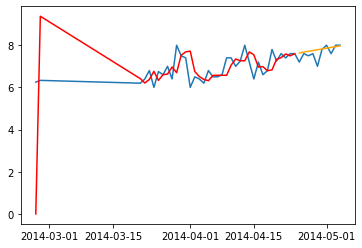

Test MSE: 0.10917739090319803 			for 2, 2 and 2


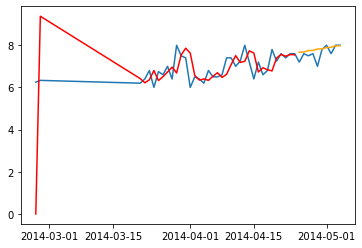

Test MSE: 0.5111790215591169 			for 3, 0 and 0


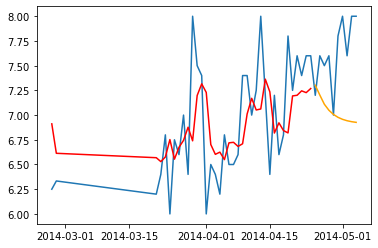

Test MSE: 0.5091226346181609 			for 3, 0 and 1


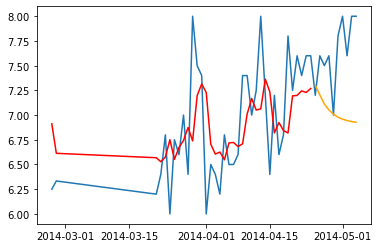

Test MSE: 0.5084106473949717 			for 3, 0 and 2


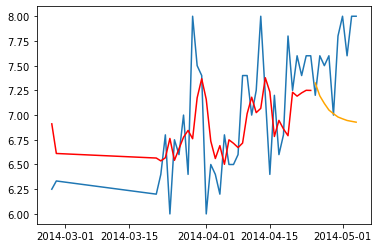

Test MSE: 0.10805757404479284 			for 3, 1 and 0


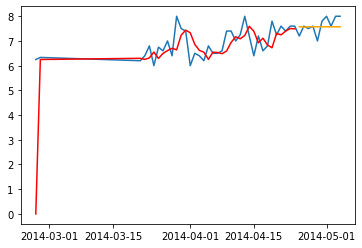

Test MSE: 0.1914061245279568 			for 3, 1 and 1


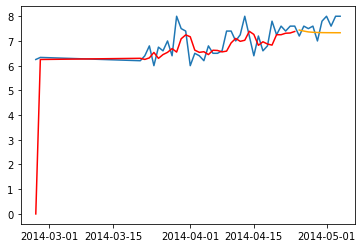

Test MSE: 0.18843966351392066 			for 3, 1 and 2


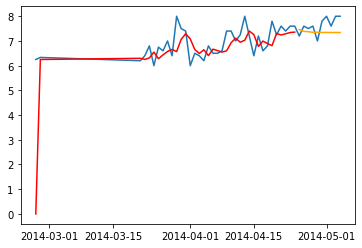

Test MSE: 0.17805466682312274 			for 3, 2 and 0


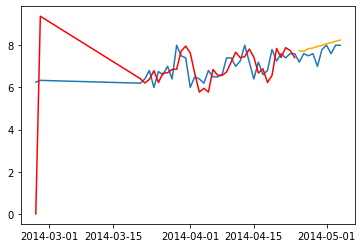

Test MSE: 0.1021862527646579 			for 3, 2 and 1


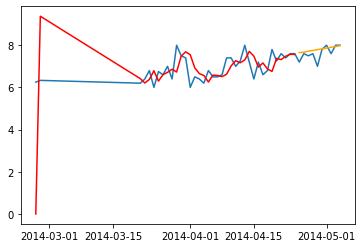

Test MSE: 0.11247457956924409 			for 3, 2 and 2


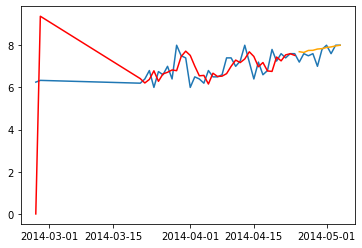

Test MSE: 0.4909724110869935 			for 4, 0 and 0


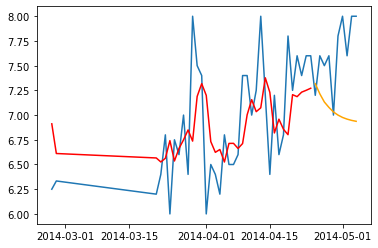

Test MSE: 0.47485513191706447 			for 4, 0 and 1


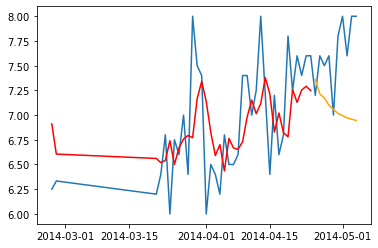

Test MSE: 0.45391877300234984 			for 4, 0 and 2


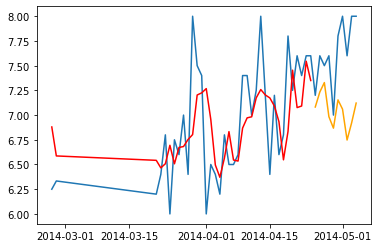

Test MSE: 0.10743697017222978 			for 4, 1 and 0


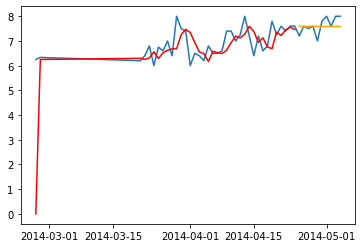

Test MSE: 0.10921297097840592 			for 4, 1 and 1


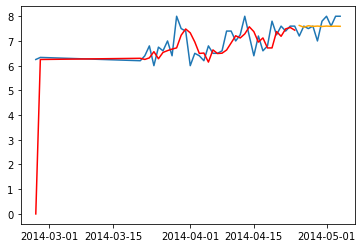

Test MSE: 0.1862112589302961 			for 4, 1 and 2


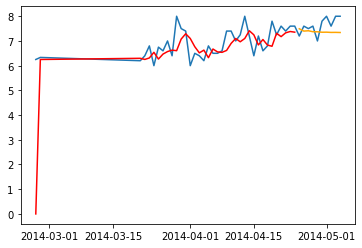

Test MSE: 0.12589316800490838 			for 4, 2 and 0


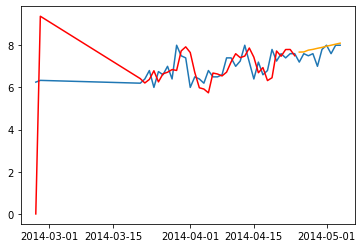

Test MSE: 0.1081668513876266 			for 4, 2 and 1


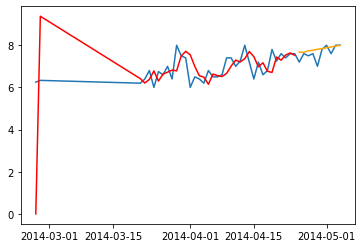

Test MSE: 0.11570794239912549 			for 4, 2 and 2


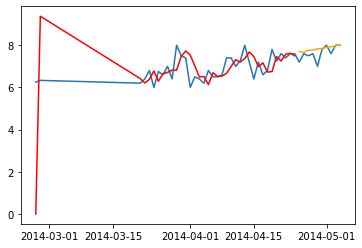

In [15]:
# pdq analysis on full mood range
pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values)
pdq_results.sort_values('mse', inplace = True)
pdq_results = pdq_results.reset_index()

# pdq analysis on cutoff mood range
pdq_results_cutoff = do_experiment_ARIMA_find_pdq_values(mood_cutoff, p_values, d_values, q_values)
pdq_results_cutoff.sort_values('mse', inplace = True)
pdq_results_cutoff = pdq_results_cutoff.reset_index()

# pdq analysis on dropna mood range
pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values)
pdq_results_dropna.sort_values('mse', inplace = True)
pdq_results_dropna = pdq_results_dropna.reset_index()

In [16]:
dfs_pdq = [pdq_results, pdq_results_cutoff, pdq_results_dropna]

df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)
print('1=full range, 2=cutoff, 3=dropna')
df_pdq

1=full range, 2=cutoff, 3=dropna


index1  p1  d1  q1       mse1  tr_na1  tr1  tst1  index2  p2  ...  tr2  \
0       25   2   2   1   0.061010      32   62    15       8   0  ...   36   
1       43   4   2   1   0.061650      32   62    15      34   3  ...   36   
2       44   4   2   2   0.066888      32   62    15      35   3  ...   36   
3       35   3   2   2   0.068116      32   62    15      43   4  ...   36   
4       34   3   2   1   0.071313      32   62    15      44   4  ...   36   
5       16   1   2   1   0.072469      32   62    15      25   2  ...   36   
6       26   2   2   2   0.072953      32   62    15      17   1  ...   36   
7       12   1   1   0   0.082200      32   62    15      16   1  ...   36   
8       17   1   2   2   0.118070      32   62    15      26   2  ...   36   
9        3   0   1   0   0.127500      32   62    15       4   0  ...   36   
10      21   2   1   0   0.137996      32   62    15      30   3  ...   36   
11      39   4   1   0   0.140644      32   62    15      39   4  ...   36   
12       8   0   2   2   0.147938      32   62    15       7   0  ...   36   
13      30   3   1   0   0.170502      32   62    15      40   4  ...   36   
14       7   0   2   1   0.265878      32   62    15      21   2  ...   36   
15       4   0   1   1   0.312936      32   62    15       5   0  ...   36   
16       5   0   1   2   0.351091      32   62    15      12   1  ...   36   
17      32   3   1   2   0.360923      32   62    15      13   1  ...   36   
18      23   2   1   2   0.363685      32   62    15      23   2  ...   36   
19      13   1   1   1   0.365524      32   62    15      14   1  ...   36   
20      22   2   1   1   0.374998      32   62    15      32   3  ...   36   
21      31   3   1   1   0.375219      32   62    15      22   2  ...   36   
22      41   4   1   2   0.375717      32   62    15      31   3  ...   36   
23      40   4   1   1   0.376340      32   62    15      41   4  ...   36   
24      14   1   1   2   0.377054      32   62    15       3   0  ...   36   
25      29   3   0   2   0.525683      32   62    15      38   4  ...   36   
26      18   2   0   0   0.653625      32   62    15      29   3  ...   36   
27      19   2   0   1   0.653784      32   62    15      37   4  ...   36   
28      27   3   0   0   0.653857      32   62    15      10   1  ...   36   
29      28   3   0   1   0.653864      32   62    15      36   4  ...   36   
30      36   4   0   0   0.653879      32   62    15      28   3  ...   36   
31      20   2   0   2   0.654017      32   62    15      27   3  ...   36   
32      10   1   0   1   0.654448      32   62    15      19   2  ...   36   
33       2   0   0   2   0.655108      32   62    15      11   1  ...   36   
34      37   4   0   1   0.655277      32   62    15      20   2  ...   36   
35       9   1   0   0   0.655513      32   62    15      18   2  ...   36   
36      11   1   0   2   0.657835      32   62    15       9   1  ...   36   
37       1   0   0   1   0.659963      32   62    15       2   0  ...   36   
38       0   0   0   0   0.665948      32   62    15       0   0  ...   36   
39      38   4   0   2   0.667637      32   62    15       1   0  ...   36   
40      42   4   2   0   7.028396      32   62    15      42   4  ...   36   
41      33   3   2   0   7.740036      32   62    15      33   3  ...   36   
42      24   2   2   0  11.715018      32   62    15      24   2  ...   36   
43      15   1   2   0  39.064554      32   62    15      15   1  ...   36   
44       6   0   2   0  84.867500      32   62    15       6   0  ...   36   

    tst2  index3  p3  d3  q3      mse3  tr_na3  tr3  tst3  
0      9      17   1   2   2  0.079995      37   37    10  
1      9       8   0   2   2  0.092015      37   37    10  
2      9      25   2   2   1  0.098613      37   37    10  
3      9       7   0   2   1  0.099891      37   37    10  
4      9      34   3   2   1  0.102186      37   37    10  
5      9      16   1   2   1  0.104213      37   37    

Unexpected results to me, I would not have expected that the full range (with a very long gap between the first days and the rest of the days) would perform better than the cutoff-range or the ranges with NaN dropped.

So it seems like it's not necessary to cut off the period or remove NaNs? We still do a further analysis of this though because it seems unexpected.

Test MSE: 0.06101042177970197 	for 2, 2 and 1


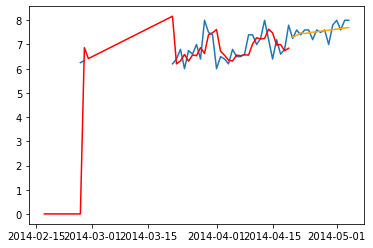

Test MSE: 0.07720755312735066 	for 0, 2 and 2


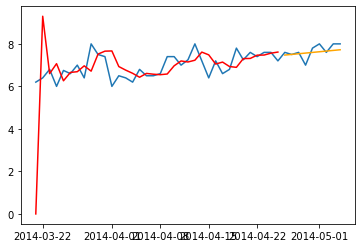

Test MSE: 0.0799948970424992 	for 1, 2 and 2


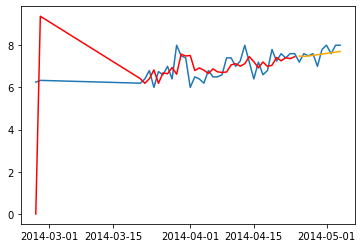

In [17]:
perform_ARIMA(mood, (2,2,1))
perform_ARIMA(mood_cutoff, (0,2,2))
perform_ARIMA(mood_dropna, (1,2,2))

In [18]:
print(f'Full range has {df_pdq["tr_na1"][0]} non-NaN training values (out of {df_pdq["tr1"][0]}) and {df_pdq["tst1"][0]} test values')
print(f'Cutoff range has {df_pdq["tr_na2"][0]} non-NaN training values (out of {df_pdq["tr2"][0]}) and {df_pdq["tst2"][0]} test values')
print(f'Dropnan range has {df_pdq["tr_na3"][0]} non-NaN training values (out of {df_pdq["tr3"][0]}) and {df_pdq["tst3"][0]} test values')

Full range has 32 non-NaN training values (out of 62) and 15 test values
Cutoff range has 36 non-NaN training values (out of 36) and 9 test values
Dropnan range has 37 non-NaN training values (out of 37) and 10 test values


The full range has less non-NaN values to train on and more values to test on than the cutoff/dropna range. Makes it even weirder for me that it performs better.

But on the other hand: this might not even be a big problem. Let's see how many persons have missing mood data. 

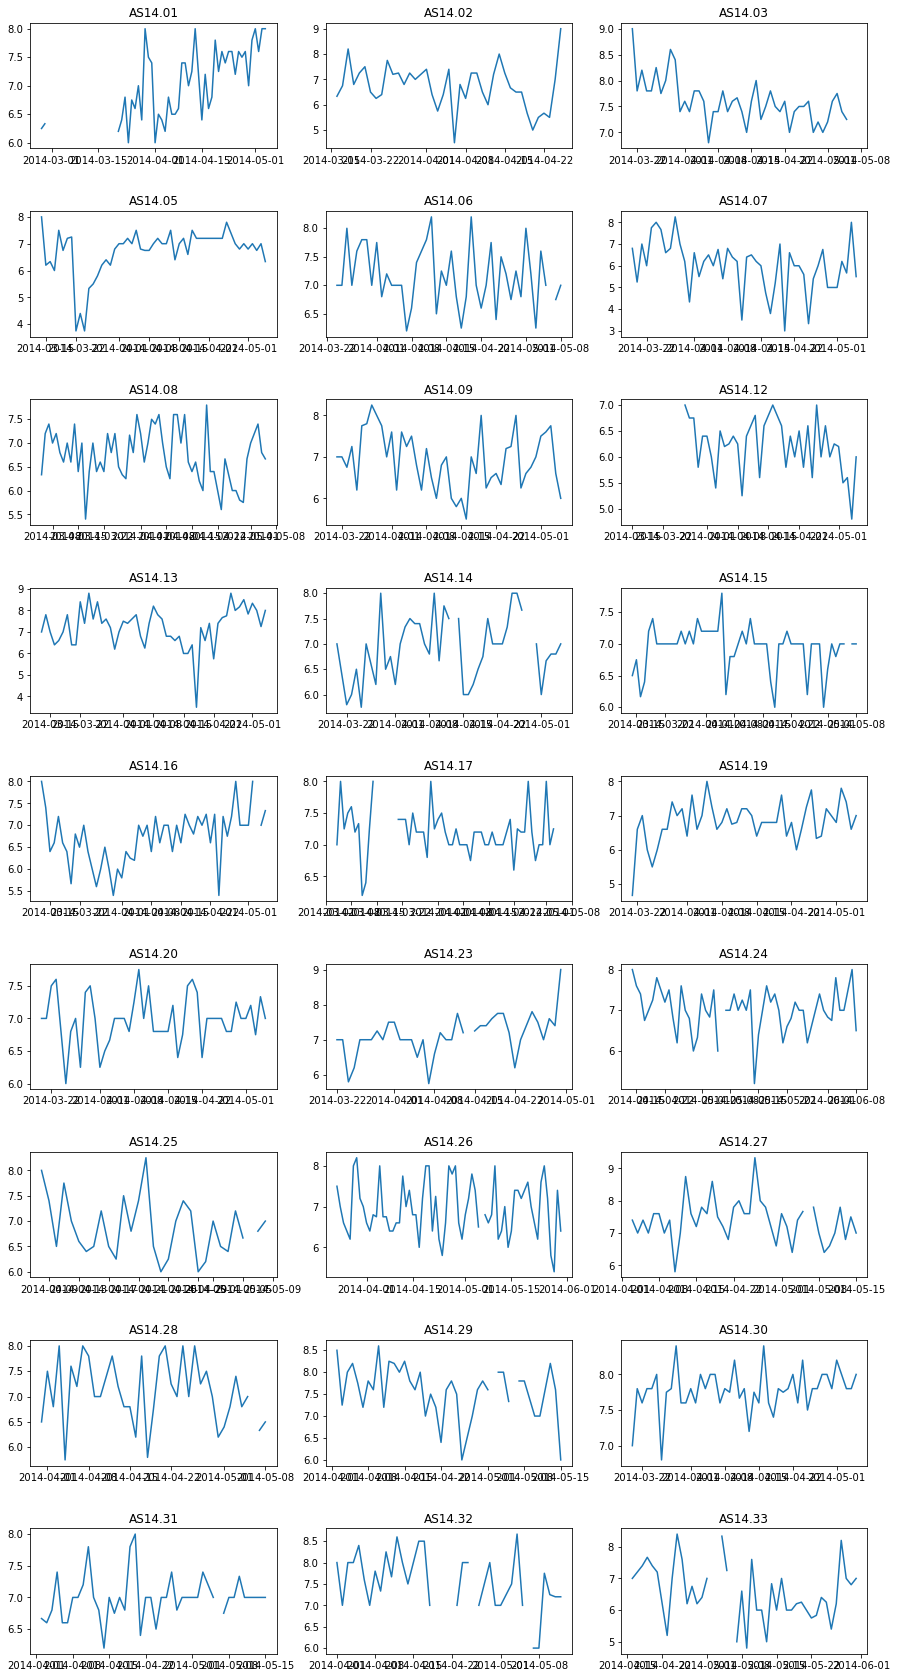

In [19]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df.id.unique()) / 3)), ncols=3)
fig.set_figheight(30)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)

# Plot mood for each person
for ax, person in zip(axes.flatten(), df.id.unique()):
    mood = getPersonMoodArimaSet(person)
    ax.set(title=person)
    ax.plot(mood)

Not a lot, so this may not be relevant. We can probably just use ARIMA on the full set. For reference, the following persons have some big chunks of missing data:
- AS14.01 in the beginning
- AS14.17 in the beginning
- AS14.32 in the middle

Furthermore, some persons have small gaps in the end at the test set. Will look into this later.

For the sake of completeness, we will try all 2 sets on each person and see which dataset performs best.

In [20]:
df_results = pd.DataFrame(columns=df_pdq.columns[0:16], index=df.id.unique()) # init

# Do p,d,q experiment for each person, for each dataset
for person in df.id.unique():

    # Get mood set
    mood = getPersonMoodArimaSet(person)
    
    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Results for complete set
    pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values, doPrint=False)
    pdq_results.sort_values('mse', inplace = True)
    pdq_results = pdq_results.reset_index()

    # Results for set with dropped NaN
    pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values, doPrint=False)
    pdq_results_dropna.sort_values('mse', inplace = True)
    pdq_results_dropna = pdq_results_dropna.reset_index()
    
    # Get best results
    dfs_pdq = [pdq_results, pdq_results_dropna]
    df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
    df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)

    # Save best orders and their mse 
    df_results.loc[person] = df_pdq.loc[0]

In [21]:
df_results.to_csv('results/arima.csv')

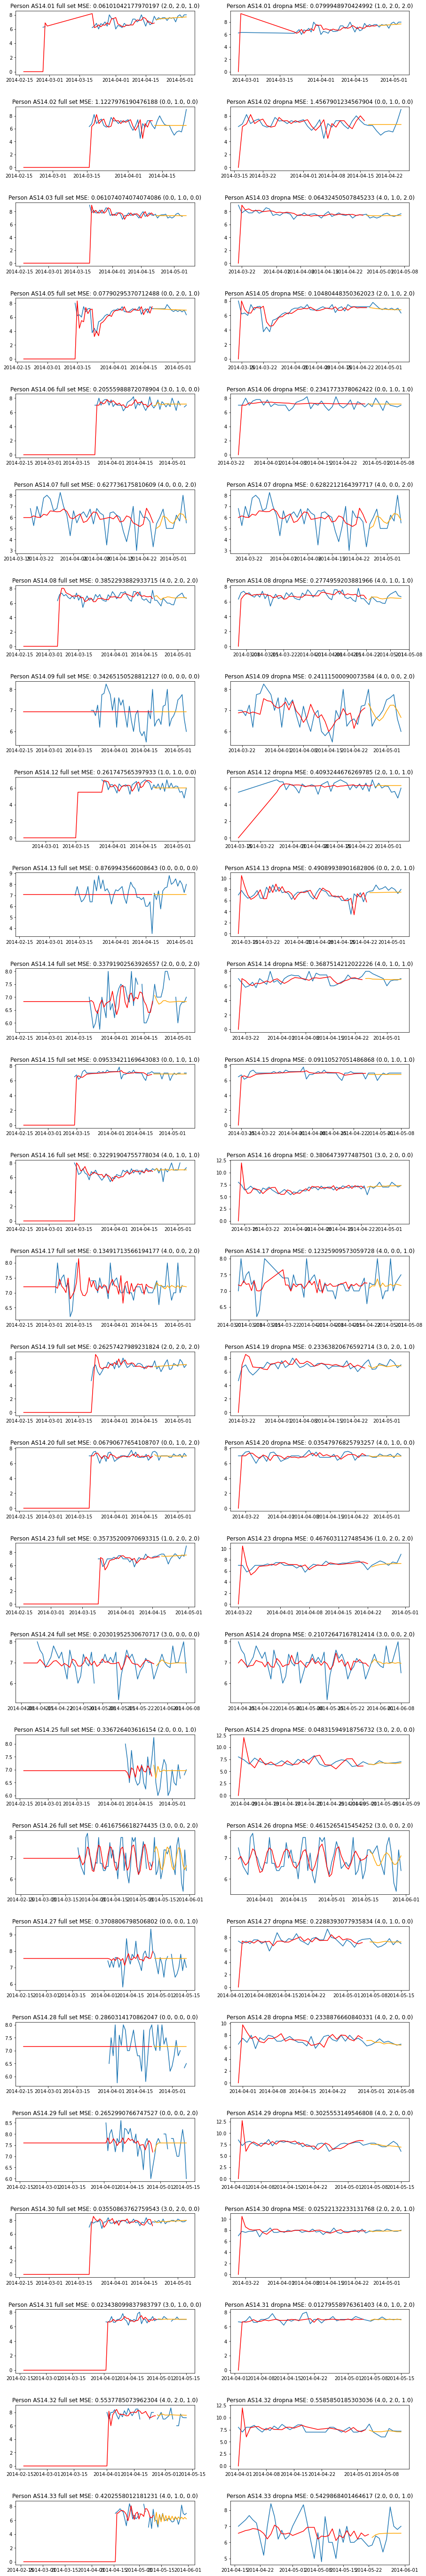

In [23]:
# Plotting stuff
fig, axes = plt.subplots(nrows=int(len(df.id.unique())), ncols=2)
fig.set_figheight(100)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)
axs = axes.flatten()

# Plot arima fitted values and forecasting for each person
for i, person in enumerate(df.id.unique()):
    
    # Get mood set
    mood = getPersonMoodArimaSet(person)

    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Get training and test sets
    train, test = get_train_set_set(mood, perc_train)
    train_dropna, test_dropna = get_train_set_set(mood_dropna, perc_train)
    
    # Get arima orders
    pdq = (df_results.loc[person].p1, df_results.loc[person].d1, df_results.loc[person].q1)
    pdq_dropna = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    # Train the models
    model = ARIMA(train, order=pdq)
    model_fit = model.fit()
    model_dropna = ARIMA(train_dropna, order=pdq_dropna)
    model_fit_dropna = model_dropna.fit()

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    forecast_dropna = model_fit_dropna.forecast(len(test_dropna))
    mse_dropna = mean_squared_error(test_dropna, forecast_dropna)

    # Make axes
    ax = axs[i*2]
    ax_dropna = axs[i*2+1]
    
    # Plot full range
    ax.set_title(f'Person {person} full set MSE: {mse} {pdq}')
    ax.plot(mood)
    ax.plot(model_fit.fittedvalues, color='red')
    ax.plot(test.index, forecast, color='orange')
    
    # Plot dropped NaN
    ax_dropna.set_title(f'Person {person} dropna MSE: {mse_dropna} {pdq_dropna}')
    ax_dropna.plot(mood_dropna)
    ax_dropna.plot(model_fit_dropna.fittedvalues, color='red')
    ax_dropna.plot(test_dropna.index, forecast_dropna, color='orange')

Let's analyse which mood dataset performs better and what the training / test sets look like.

In [24]:
df_results['best'] = np.where(df_results['mse1'] < df_results['mse2'], 'full', 'nan')
df_results['diff'] =  np.where(df_results['mse1'] < df_results['mse2'], df_results['mse2'] - df_results['mse1'], df_results['mse1'] - df_results['mse2'])

print(f'Mean MSE of full range is \t{df_results["mse1"].mean()}')
print(f'Mean MSE of dropnan range is \t{df_results["mse2"].mean()}')

df_results

Mean MSE of full range is 	0.3169718609576978
Mean MSE of dropnan range is 	0.30789154208311365


index1 p1 d1 q1       mse1 tr_na1 tr1 tst1 index2 p2 d2 q2       mse2  \
AS14.01     25  2  2  1  0.0610104     32  62   15     17  1  2  2  0.0799949   
AS14.02      3  0  1  0     1.1228     27  54   14      3  0  1  0    1.45679   
AS14.03      3  0  1  0  0.0610741     32  64   15     41  4  1  2  0.0643245   
AS14.05      7  0  2  1   0.077903     37  61   16     23  2  1  2   0.104804   
AS14.06     30  3  1  0    0.20556     29  64   16      4  0  1  1   0.234177   
AS14.07     38  4  0  2   0.627736     38  40   10     38  4  0  2   0.628221   
AS14.08     44  4  2  2   0.385229     46  62   16     40  4  1  1   0.277496   
AS14.09      0  0  0  0   0.342652     30  62   16     38  4  0  2   0.241115   
AS14.12     12  1  1  0   0.261748     25  60   16     22  2  1  1   0.409324   
AS14.13      0  0  0  0   0.876994     37  61   16      7  0  2  1   0.490899   
AS14.14     20  2  0  2   0.337919     30  62   14     40  4  1  1   0.368751   
AS14.15      4  0  1  1  0.0953342     39  64   16      4  0  1  1  0.0911053   
AS14.16     40  4  1  1   0.322919     38  62   15     33  3  2  0   0.380647   
AS14.17     38  4  0  2   0.134917     41  62   15     37  4  0  1   0.123259   
AS14.19     26  2  2  2   0.262574     30  62   16     34  3  2  1   0.233638   
AS14.20      5  0  1  2  0.0679068     31  62   16     39  4  1  0  0.0354798   
AS14.23     17  1  2  2   0.357352     27  61   12     17  1  2  2   0.467603   
AS14.24     27  3  0  0    0.20302     43  49   12     29  3  0  2   0.210726   
AS14.25     19  2  0  1   0.336726     14  64   16     33  3  2  0  0.0483159   
AS14.26     29  3  0  2   0.461676     47  82   21     29  3  0  2   0.461527   
AS14.27      1  0  0  1   0.370881     25  70   17     39  4  1  0   0.228839   
AS14.28      0  0  0  0   0.286031     22  64   16     42  4  2  0   0.233888   
AS14.29      2  0  0  2   0.265299     26  70   16     42  4  2  0   0.302555   
AS14.30     33  3  2  0  0.0355086     31  62   16     25  2  2  1  0.0252213   
AS14.31     30  3  1  0  0.0234381     28  72   15     41  4  1  2  0.0127956   
AS14.32     43  4  2  1   0.553779     22  69   15     43  4  2  1   0.558585   
AS14.33     39  4  1  0   0.420256     22  83   21     19  2  0  1   0.542987   

        tr_na2 tr2 tst2  best         diff  
AS14.01     37  37   10  full    0.0189845  
AS14.02     32  32    9  full     0.333993  
AS14.03     37  37   10  full   0.00325043  
AS14.05     42  42   11  full    0.0269015  
AS14.06     36  36    9  full    0.0286174  
AS14.07     38  38   10  full  0.000485041  
AS14.08     49  49   13   nan     0.107733  
AS14.09     36  36   10   nan     0.101537  
AS14.12     32  32    9  full     0.147577  
AS14.13     42  42   11   nan     0.386095  
AS14.14     35  35    9  full    0.0308324  
AS14.15     44  44   11   nan   0.00422894  
AS14.16     42  42   11  full    0.0577284  
AS14.17     44  44   12   nan     0.011658  
AS14.19     36  36   10   nan    0.0289361  
AS14.20     37  37   10   nan     0.032427  
AS14.23     31  31    8  full     0.110251  
AS14.24     44  44   11  full   0.00770695  
AS14.25     24  24    6   nan      0.28841  
AS14.26     54  54   14   nan   0.00014912  
AS14.27     33  33    9   nan     0.142041  
AS14.28     30  30    8   nan    0.0521438  
AS14.29     33  33    9  full    0.0372562  
AS14.30     37  37   10   nan    0.0102873  
AS14.31     34  34    9   nan    0.0106425  
AS14.32     29  29    8  full   0.00480651  
AS14.33     34  34    9  full     0.122731

In [25]:
df_results_final = df_results.rename(columns = {'mse2': 'mse'}).mse
df_results_final.to_csv('results/arima_final.csv')